In [1]:
#import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from pandas import DataFrame, read_csv

%matplotlib tk

C:\Users\33614\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
#load data
# file path of csv file
Location = r'/Users/33614/ExternalDrive/SUPAERO/PIR_2A/Data/data_spikes/E18KABaseline_Bcut.txt'
#Location = r'/Users/SYL21/D_Drive/SUPAERO/PIR_2A/Data/data_spikes/E18KABaseline_Bcut.txt'
#Location = r'/Users/louiseplacidet/Desktop/PIR/Data/data_spikes/E18KABaseline_Bcut.txt'

# create dataframe
df = pd.read_csv(Location, sep='\t',skiprows=[0,1,3] , index_col='%t           ')

C:\Users\33614\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#threshold

def test_valid_window(window, test_level = 5):
    """
    window : the window in the signal that has to be tested
    
    This funtion test the window to insure that it doesn't contain the signal of interest (spike)
    """
    #non zero ?
    second = np.percentile(window, 2)
    thirtyth = np.percentile(window, 30)
    #print(str(second) + "\t" + str(thirtyth) + "\t" + str(second/thirtyth))
    if abs(second/thirtyth) < test_level : 
        return True
    else : 
        return False
    

def init_noise_levels(signal, fs, 
                      noise_window_size = 0.01,
                      required_valid_windows = 100,
                      old_noise_level_propagation = 0.8, 
                      test_level = 5):
    
    nb_valid_windows = 0
    list_RMS = []
    noise_levels = []
     
    #boucle en indice
    for window_index in range(0,len(signal)-(len(signal)%int(fs*noise_window_size)),int(fs*noise_window_size)):
        test = test_valid_window(signal.iloc[window_index: window_index + int(fs*noise_window_size)], test_level)
        if nb_valid_windows < required_valid_windows:
            if test == True :
                RMS = np.sqrt(np.mean(signal.iloc[window_index: window_index + int(fs*noise_window_size)]**2))
                list_RMS.append(RMS)
                nb_valid_windows += 1
            
            if nb_valid_windows == required_valid_windows:
                noise_level = np.percentile(list_RMS, 25)
                for elm in range(0, window_index, int(fs*noise_window_size)):
                    noise_levels.append(noise_level)
                
        else :
            """if test == True:
                if (window + int(fs*noise_window_size)) > (len(signal)-1) :
                    N25 = np.percentile(abs(signal.iloc[window:]), 25)
                else :
                    N25 = np.percentile(abs(signal.iloc[window: window + int(fs*noise_window_size)]), 25)
                noise_level = old_noise_level_propagation*noise_level + (1-old_noise_level_propagation)*N25
            noise_levels.append(noise_level)"""
            if test == True:
                if (window_index + int(fs*noise_window_size)) > (len(signal)-1) :
                    RMS = np.sqrt(np.mean(signal.iloc[window_index:]**2))
                else :
                    RMS = np.sqrt(np.mean(signal.iloc[window_index: window_index + int(fs*noise_window_size)]**2))
                list_RMS.append(RMS)
                N25 = np.percentile(list_RMS, 25)
                new_noise_level = old_noise_level_propagation*noise_level + (1-old_noise_level_propagation)*N25
                noise_level = new_noise_level
            noise_levels.append(noise_level)
            
    plt.figure()
    plt.plot(list_RMS)
    plt.xlabel('Time')
    plt.grid()
                
    return noise_levels
            

In [4]:
#find spike

def find_spike(signal, initial_index, noise_levels, fs, spike_centers, 
               window_size = 0.001, 
               noise_window_size = 0.01,
               threshold_factor = 4):
    if initial_index < len(signal):
        i = initial_index
        for value in signal.iloc[initial_index:]:
            #print(int((i/fs)//noise_window_size))
            if value > threshold_factor*noise_levels[int((i/fs)//noise_window_size)]:
                while(True):
                    if i > initial_index + window_size*fs:
                        b_point = int(i - window_size*fs)
                    else :
                        b_point = initial_index
                    if i < len(signal)-window_size*fs-1:
                        e_point = int(i + window_size*fs)
                    else :
                        e_point = len(signal)-1

                    highest_value = signal.iloc[b_point: e_point].max()

                    if highest_value == value : # && 50% amplitude
                        spike_centers.append(i)
                        return e_point
                    
                    else:
                        #i = signal.index.get_loc(highest)
                        i = int(signal.iloc[b_point: e_point].idxmax()*fs/1000)#index(highest_value)#+b_point
                        value = signal.iloc[i]
                        
                break
                    
            if value < -threshold_factor*noise_levels[int((i/fs)//noise_window_size)]:
                while(True):
                    if i > initial_index + window_size*fs:
                        b_point = int(i - window_size*fs)
                    else :
                        b_point = initial_index
                    if i < len(signal)-window_size*fs-1:
                        e_point = int(i + window_size*fs)
                    else :
                        e_point = len(signal)-1

                    lowest_value = min(signal.iloc[b_point: e_point])

                    if lowest_value == value : # && 50% amplitude
                        spike_centers.append(i)                        
                        return e_point
                    
                    else:
                        #i = signal.index.get_loc(lowest)
                        i = int(signal.iloc[b_point: e_point].idxmin()*fs/1000)#Index.get_loc(lowest_value)#+b_point
                        value = signal.iloc[i]
                        
                break
                  
            i += 1
    return -2
            
def find_spikes(signal, noise_levels, fs, 
               window_size = 0.001, 
               noise_window_size = 0.01,
               threshold_factor = 4):
    
    initial = 0
    spike_centers = []
    
    while initial != -2:
        initial = find_spike(signal, initial, noise_levels, fs, spike_centers,
                             window_size = window_size, 
                             noise_window_size = noise_window_size,
                             threshold_factor = threshold_factor)
    
    return spike_centers

In [5]:
#record spike

def record_spikes(signal, fs, spike_centers, 
                  t_before = 0.001, 
                  t_after = 0.002):
    data = np.array([x for x in range(fs*(t_before+t_after)+1)])
    
    for center in spike_centers:
        if center < fs*t_before:
            spike = [0 for i in range(0, fs*t_before-center)]
            spike = np.concatenate(spike, signal[:center + fs*t_after])
            np.insert(data, len(data), spike, axis=0)
            
        elif center > len(signal)-fs*t_after:
            spike = signal[center-fs*t_before:]
            spike = np.concatenate(spike,[0 for i in range(0, fs*t_after-(len(signal)-center))])
            np.insert(data, len(data), spike, axis=0)
            
        else :
            spike = signal[center - fs*t_before: center + fs*t_after]
            np.insert(data, len(data), spike, axis=0)
            
    spike_data = pd.DataFrame(data[:,1:], index = data[:,0], columns=spike_centers)
    
    return spike_data

In [6]:
signal = df.iloc[:,1]
signal

%t           
0.00        -1.02
0.04        -3.30
0.08        -3.86
0.12        -3.41
0.16        -4.20
0.20        -1.82
0.24        -1.48
0.28        -2.39
0.32        -2.73
0.36        -3.64
0.40        -2.73
0.44         0.23
0.48         0.80
0.52         0.91
0.56        -1.82
0.60        -3.07
0.64        -2.39
0.68        -4.43
0.72        -4.32
0.76        -2.50
0.80        -0.23
0.84         1.36
0.88         0.80
0.92        -1.59
0.96        -2.50
1.00        -3.30
1.04        -2.50
1.08        -1.02
1.12        -0.91
1.16        -2.73
             ... 
301798.80    0.80
301798.84    1.48
301798.88   -1.48
301798.92   -1.70
301798.96   -2.50
301799.00   -1.59
301799.04   -0.45
301799.08   -1.48
301799.12   -1.70
301799.16   -0.91
301799.20   -2.16
301799.24   -1.82
301799.28   -1.70
301799.32   -2.50
301799.36   -4.20
301799.40   -6.14
301799.44   -5.00
301799.48   -1.02
301799.52    1.14
301799.56    2.84
301799.60    4.66
301799.64    5.57
301799.68    3.41
301799.72    2

C:\Users\33614\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


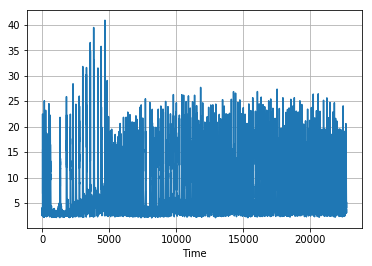

In [7]:
# test of the functions

signal = df.iloc[:,1]
fs = 25000

noise_levels = init_noise_levels(signal, fs, 
                      noise_window_size = 0.01,
                      required_valid_windows = 100,
                      old_noise_level_propagation = 0.8, 
                      test_level = 5)

In [23]:
plt.figure()
plt.plot(noise_levels)
plt.xlabel('Time')
plt.grid()

In [ ]:
spike_centers = find_spikes(signal, noise_levels, fs, 
                           window_size = 0.001, 
                           noise_window_size = 0.01,
                           threshold_factor = 4)

spike_centers

In [ ]:
spike_data = record_spikes(signal, fs, spike_centers, 
                  t_before = 0.001, 
                  t_after = 0.002)

In [23]:
a = [0,3,4,2,4,5,3]
np.percentile(a[1: 4], 25)

2.5

In [ ]:
plt.figure(figsize = (100,20))
plt.plot(spike_data.index, spike_data.iloc[:,1])
plt.xlabel('Time')
plt.grid()